In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import itertools
from scipy.stats import spearmanr

from pathlib import Path

import os
import sys  

# set path for pixelator directory 
sys.path.insert(0, "/Users/janrkauert/pixelator/")

# load functions from pixelator
from pixelator.pixeldataset import PixelDataset
from pixelator.graph import Graph

# load standard workflow single cell functions
from colocalization_measures.plot import plot_mutliple_markers
from colocalization_measures.higher_order_similarity import calculate_higher_order_similarity
from colocalization_measures.adjusted_local_assortativity import calculate_adjusted_local_assorativity
from colocalization_measures.colocalization_scores import create_colocalization_scores

# get directory with graph eval files
path_name = "C:/Users/janrh/Downloads/Rituximab"

In [2]:
# new graph for all data
sample_list = []
pxl_data_list = []

for index_place, file in enumerate(sorted(os.listdir(path_name))[1:2]):
    
    # get name of current file in directory
    filename = os.fsdecode(file)

    # load marker edge list
    pxl_data = PixelDataset.from_file(path_name + "/" + filename)
    edge_list_df = pxl_data.edgelist   

    edge_list_df.columns = [col.lower() for col in edge_list_df.columns]

    # build the graph
    graph = Graph.from_edgelist(edgelist=edge_list_df,
                                add_marker_counts=True,
                                simplify=False,
                                use_full_bipartite=False)
    mega_graph = graph._raw
    
    # add filename as a vertex attribute
    mega_graph.es["sample"] = [filename] * mega_graph.ecount()

    sample_list.append(mega_graph)
    pxl_data_list.append(pxl_data)

    print(filename)

Sample04_Raji_Rituximab_treated_001.dataset.pxl


In [3]:
# select sample to work on
sample_index = 0

# subgraphs of the selected sample
graph_component_subgraphs = sample_list[sample_index].components().subgraphs()

# load edge list from pixelator dataset
df = pxl_data_list[sample_index].edgelist

# create dictionary form all pixel names for each component
dict_comp_A = dict(zip(df["upia"].values, df["component"].values))
dict_comp_B = dict(zip(df["upib"].values, df["component"].values))

# create a set for all UPIA and UPIB for fast assessments
set_comp_A_pixels = set(df["upia"].values)
set_comp_B_pixels = set(df["upib"].values)

In [4]:
# non zero pairwise markers for the Rituximab experiment
marker_names = ["CD27", "CD55", "CD48", "CD82", "CD54", "CD44", "B2M", "CD18", "CD37", "CD29", "CD11a", "CD47", "CD45", "CD22", 
                "CD19", "CD72", "CD59", "CD38", "CD26", "CD197", "CD71", "CD40", "CD45RA", "CD84", "CD49D", "CD32", "HLA-ABC", 
                "CD86", "HLA-DR"]

# get all combinations with CD20
combinations = list(itertools.product(["Rituximab"], marker_names))

In [5]:
marker_names = ["Rituximab"] + marker_names
path_data = "C:/Users/janrh/Documents/GitHub/TDA-local-assortativity-paper/Rituximab/Treated"

# calculate pairwise colocalization scores
similarity_measure_df = create_colocalization_scores(combinations, path_data, combinations)

In [6]:
similarity_measure_df["Marker_combinations"] = ["CD20" + label[9:] for label in similarity_measure_df.index]
similarity_measure_df = similarity_measure_df.set_index("Marker_combinations")

In [7]:
smlr_df = similarity_measure_df.mean(axis=1)

# create new dataframe to store the abundance of the markers per component
df_abundance = pd.DataFrame()
df_abundance["markers"] = marker_names


for comp_index, component in enumerate(graph_component_subgraphs):

    list_abundace_comp = []
    for marker in marker_names:
        
        # get the total number of marker counts for each marker in the list
        abundance = [vertex["markers"][marker] for vertex in component.vs]
        list_abundace_comp.append(sum(abundance))

    df_abundance["comp_" + str(comp_index)] = list_abundace_comp


In [8]:
df_abundance_old = df_abundance.copy()

In [9]:
df_abundance = df_abundance_old.copy()

In [10]:
# set index dataframe and get min abundance for each marker across all components
df_abundance = df_abundance.set_index("markers").T.mean()

In [11]:
df = pd.DataFrame(df_abundance)
df["markers"] = ["CD20"] + df.index.to_list()[1:]
df_abundance = df.set_index("markers")

In [12]:
max_abundance = []
for marker_combination in smlr_df.index.values:

    # get marker names from the combinations in the similarity dataframe
    marker_0 = marker_combination.split("_")[0]
    marker_1 = marker_combination.split("_")[1]

    # get maximum abundance for the marker pair based on the abundance dataframe
    max_abundance.append(np.min(df_abundance[df_abundance.index == marker_1].values[0]))

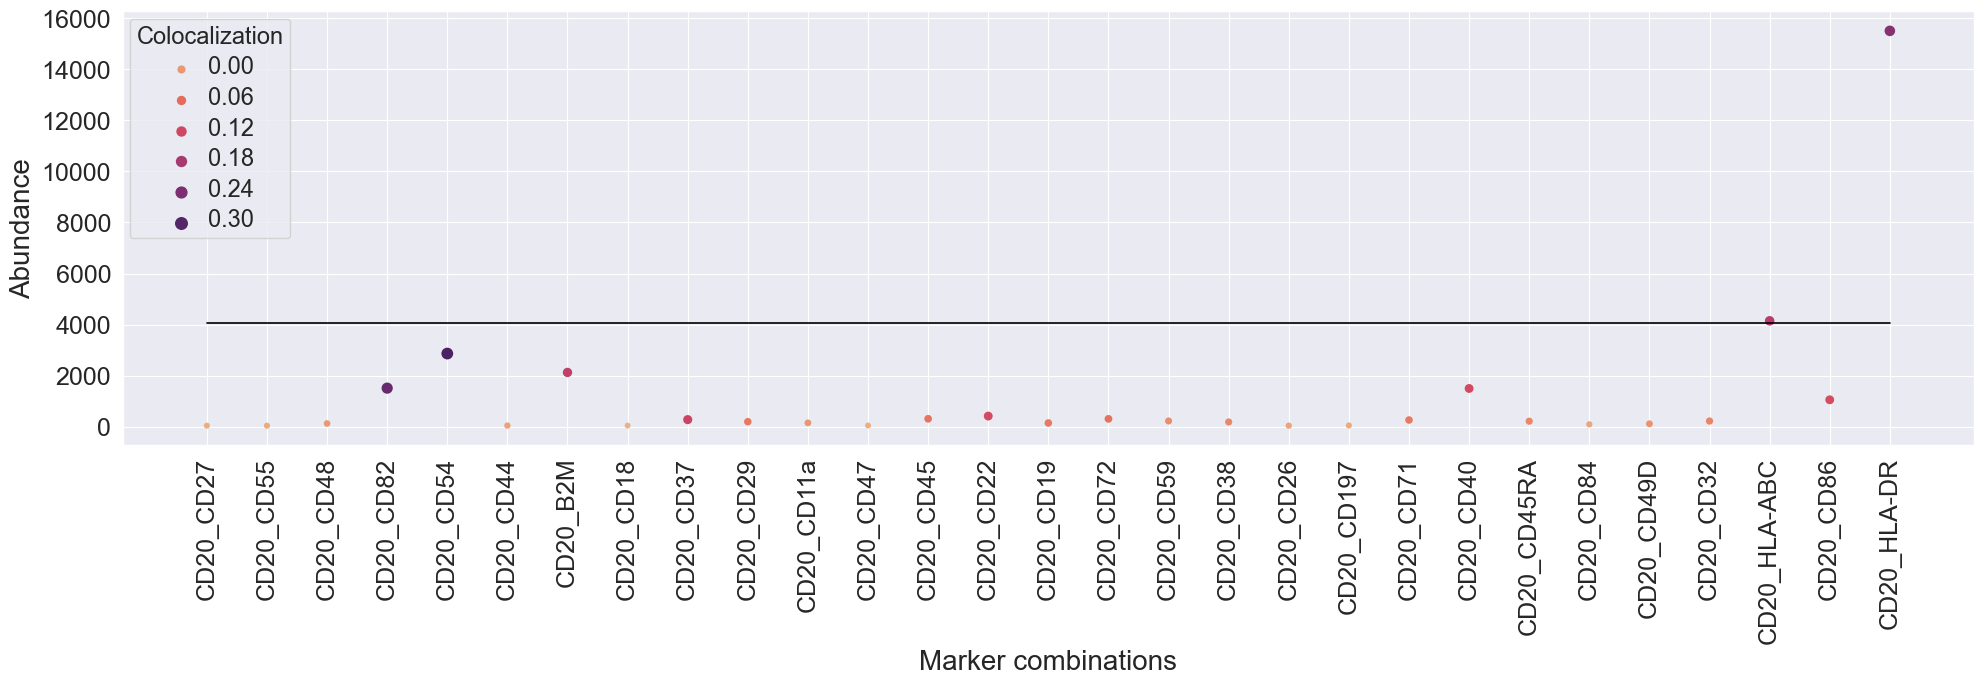

In [20]:
sns.set(rc={'figure.figsize':(20, 7)})
sns.set_theme(context="paper", style="darkgrid", font_scale=2.2)

# merge abundance DataFrame and similarity DataFrame
abundance_vs_smlr_df = pd.DataFrame({"markers": smlr_df.index.values, "Colocalization": smlr_df.values, "Abundance": max_abundance})
abundance_vs_smlr_df = abundance_vs_smlr_df.set_index("markers")

# plot line for average CD20 abundance
sns.lineplot(list(df_abundance[df_abundance.index == "CD20"].values[0]) * len(abundance_vs_smlr_df), color="black")

# create a scatter plot highlithing the correlation between abundance and pairwise colocalization
sns.set(rc={'figure.figsize':(20, 7)})
ax = sns.scatterplot(x=abundance_vs_smlr_df.index.values, y=abundance_vs_smlr_df["Abundance"], 
                hue=abundance_vs_smlr_df["Colocalization"], palette="flare", size=abundance_vs_smlr_df["Colocalization"], linewidth=0)

# add labels and adjust text size
plt.xlabel("Marker combinations", fontsize=20)
plt.ylabel("Abundance", fontsize=20)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.setp(ax.get_legend().get_title(), fontsize="17")
plt.setp(ax.get_legend().get_texts(), fontsize="17")

plt.tight_layout()
#plt.savefig("figure_paper.eps")